# Titanic Kaggle Competition

## Introduction

### Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import KNNImputer

### Functions

In [1]:
def get_info(df):
    print('-----  Shape  -----')
    print(df.shape)
    print('-----  Info  -----')
    print(df.info())
    print('-----  Describe  -----')
    print(df.describe())
    print('-----  Nulls?  -----')
    print(df.isna().sum())

## Obtain

### Training Data

In [16]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Testing Data

In [17]:
test_df = pd.read_csv('test.csv')
print(test_df.shape)
test_df.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Scrub

In [18]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [20]:
train_df['Cabin'].value_counts(1).sort_values(ascending = False) 

C23 C25 C27    0.019608
B96 B98        0.019608
G6             0.019608
D              0.014706
E101           0.014706
                 ...   
C95            0.004902
C148           0.004902
A23            0.004902
F G63          0.004902
D19            0.004902
Name: Cabin, Length: 147, dtype: float64

In [21]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

### Split Columns

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [23]:
cat_cols = ['Sex', 'Ticket', 'Embarked', 'Name']
num_cols = [col for col in train_df.columns if col not in cat_cols]

In [24]:
num_cols

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin']

### Categorical Columns

In [25]:
train_df[cat_cols].head()

,Sex,Ticket,Embarked,Name
0,male,A/5 21171,S,"Braund, Mr. Owen Harris"
1,female,PC 17599,C,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,female,STON/O2. 3101282,S,"Heikkinen, Miss. Laina"
3,female,113803,S,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,male,373450,S,"Allen, Mr. William Henry"


#### Name

> So this could be interesting.  We can make the assumption that each full name on the Titanic is unique.  However, if we were to slice out just the last name, we could see if there is any correlation between last name (family) and survival.

In [26]:
# Checking the assumption that each name is unique.

train_df['Name'].value_counts()

Kenyon, Mrs. Frederick R (Marion)           1
Hocking, Mrs. Elizabeth (Eliza Needs)       1
Johnston, Miss. Catherine Helen "Carrie"    1
Goncalves, Mr. Manuel Estanslas             1
Molson, Mr. Harry Markland                  1
                                           ..
Hegarty, Miss. Hanora "Nora"                1
Gustafsson, Mr. Alfred Ossian               1
Rommetvedt, Mr. Knud Paust                  1
Widegren, Mr. Carl/Charles Peter            1
Norman, Mr. Robert Douglas                  1
Name: Name, Length: 891, dtype: int64

In [27]:
last_names = []
for name in train_df['Name']:
    name = name.split(',')[0]
    last_names.append(name)

last_names

['Braund',
 'Cumings',
 'Heikkinen',
 'Futrelle',
 'Allen',
 'Moran',
 'McCarthy',
 'Palsson',
 'Johnson',
 'Nasser',
 'Sandstrom',
 'Bonnell',
 'Saundercock',
 'Andersson',
 'Vestrom',
 'Hewlett',
 'Rice',
 'Williams',
 'Vander Planke',
 'Masselmani',
 'Fynney',
 'Beesley',
 'McGowan',
 'Sloper',
 'Palsson',
 'Asplund',
 'Emir',
 'Fortune',
 "O'Dwyer",
 'Todoroff',
 'Uruchurtu',
 'Spencer',
 'Glynn',
 'Wheadon',
 'Meyer',
 'Holverson',
 'Mamee',
 'Cann',
 'Vander Planke',
 'Nicola-Yarred',
 'Ahlin',
 'Turpin',
 'Kraeff',
 'Laroche',
 'Devaney',
 'Rogers',
 'Lennon',
 "O'Driscoll",
 'Samaan',
 'Arnold-Franchi',
 'Panula',
 'Nosworthy',
 'Harper',
 'Faunthorpe',
 'Ostby',
 'Woolner',
 'Rugg',
 'Novel',
 'West',
 'Goodwin',
 'Sirayanian',
 'Icard',
 'Harris',
 'Skoog',
 'Stewart',
 'Moubarek',
 'Nye',
 'Crease',
 'Andersson',
 'Kink',
 'Jenkin',
 'Goodwin',
 'Hood',
 'Chronopoulos',
 'Bing',
 'Moen',
 'Staneff',
 'Moutal',
 'Caldwell',
 'Dowdell',
 'Waelens',
 'Sheerlinck',
 'McDermott',

In [28]:
train_df['Last Name'] = last_names
train_df.drop('Name', axis = 1, inplace = True)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Allen


In [29]:
train_df['Last Name'].value_counts()

Andersson    9
Sage         7
Carter       6
Johnson      6
Skoog        6
            ..
Hassan       1
Blank        1
O'Leary      1
Stewart      1
Cribb        1
Name: Last Name, Length: 667, dtype: int64

> As expected, there are multiple people with the same last name, potentially indicating full families on board.

### Null Values

In [30]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Last Name        0
dtype: int64

#### Age - REDO WITH KNN IMPUTER

In [31]:
train_df['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [32]:
train_df['Age'].isna().sum()

177

#### Cabin

In [33]:
train_df['Cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
F2             3
F33            3
              ..
B69            1
A16            1
D48            1
C70            1
C85            1
Name: Cabin, Length: 147, dtype: int64

In [34]:
train_df.drop('Cabin', axis = 1, inplace = True)
train_df.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Last Name
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Braund
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Cumings


#### Embarked

In [35]:
train_df['Embarked'].isna().sum()

2

In [36]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [37]:
train_df['Embarked'].fillna('S', inplace = True)
train_df['Embarked'].isna().sum()

0

#### Final Null Check

In [38]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Last Name        0
dtype: int64

### Age Groups

In [39]:
train_df['Age Group'] = train_df['Age'].copy()

In [45]:
for age in train_df['Age Group']:
    if age <= 14:
        str(age).replace(str(age), '0-14')
    elif age >= 15 and age <= 24:
        str(age).replace(str(age), '15-24')
    elif age >= 25 and age <= 49:
        str(age).replace(str(age), '25-49')
    elif age >= 50 and age <= 64:
        str(age).replace(str(age), '50-64')
    elif age > 64:
        str(age).replace(str(age), '65+')
        
train_df.head()

# age.replace

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Last Name,Age Group
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Braund,22.0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Cumings,38.0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Heikkinen,26.0
3,4,1,1,female,35.0,1,0,113803,53.1000,S,Futrelle,35.0
4,5,0,3,male,35.0,0,0,373450,8.0500,S,Allen,35.0


In [41]:
type(train_df['Age'][1])

numpy.float64

In [42]:
train_df['Age Group'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age Group, Length: 88, dtype: int64

## Explore

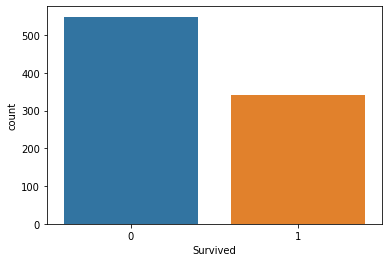

In [43]:
sns.countplot(data = train_df, x = 'Survived');

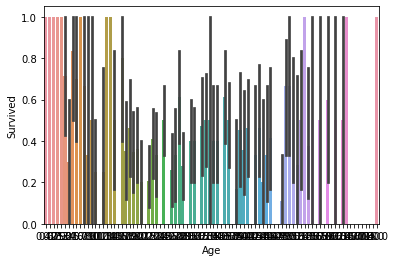

In [44]:
sns.barplot(data = train_df, x = 'Age', y = 'Survived');

## Model

## Interpret

## Conclusion